# Task 5: pixel pendulum
Sam Greydanus

In [1]:
import numpy as np
import torch, sys, io
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image, ImageDraw, ImageSequence, ImageFont
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-cart'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, make_gym_dataset, sample_gym, hamiltonian_fn, lag_energy_fn
from nn_models import MLPAutoencoder, MLP
from hnn import PixelHNN
from symoden import PixelSymODEN_R
from lagnet import PixelLagrangian
from utils import make_gif, L2_loss

In [2]:
def integrate_model(model, t_span, y0, fun=None, **kwargs):
    
    def default_fun(t, np_x):
        if isinstance(model, PixelLagrangian):
            x = torch.tensor( np_x, requires_grad=False, dtype=torch.float32).view(1,4)
        else:
            x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,4)
            
        if isinstance(model, PixelHNN):
            dx = model.time_derivative(x).data.numpy().reshape(-1)
        else:
            # append zero control
            u = torch.zeros_like(x[:,:2])
            x = torch.cat((x, u), -1)
        
            dx, dy, du = model.time_derivative(x).split(2,1)
            dx = torch.cat((dx, dy), -1).data.numpy().reshape(-1)
            
        return dx
    
    fun = default_fun if fun is None else fun

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Set some notebook constants

In [3]:
DPI = 300
LINE_SEGMENTS = 20
LINE_WIDTH = 2
FORMAT = 'pdf'

def get_args():
    return {'input_dim': 2*784,
         'hidden_dim': 300,
         'latent_dim': 4,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'print_every': 200,
         'num_frames': 400,
         'name': 'pixels',
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Make a GIF from frames in the dataset

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Successfully loaded data from ././experiment-cart/cartpole-pixels-dataset.pkl


Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.93972778320312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.849374771118164, 255.9397

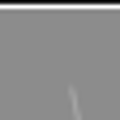

In [8]:
args = ObjectView(get_args())

# load dataset
u = [[0.0, 0.0], [0.0, 1.0], [0.0, -1.0], [0.0, 2.0], [0.0, -2.0],
     [1.0, 0.0], [-1.0, 0.0], [2.0, 0.0], [-2.0, 0.0]] 
data = get_dataset('cartpole', args.save_dir, u=u, verbose=False)
side = 28 # data['meta']['side']
trials = 200 # data['meta']['trials']
timesteps = 103 # data['meta']['timesteps']

frames = data['pixels'][:,:side**2].reshape(-1, side, side)[:args.num_frames]
name = '{}-dataset'.format(args.name)
gifname = make_gif(frames, args.fig_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

## Construct models

In [9]:
def get_HNN_model(args, name=None):
    baseline=True if name in ['baseline'] else False
    autoencoder = MLPAutoencoder(args.input_dim, 
                                 args.hidden_dim, 
                                 args.latent_dim,
                                 nonlinearity='relu')
    model = PixelHNN(args.latent_dim, 
                     args.hidden_dim,
                     autoencoder=autoencoder, 
                     nonlinearity=args.nonlinearity,
                     baseline=baseline)
    return model

def get_SymODEN_model(args, name=None):
    autoencoder = MLPAutoencoder(args.input_dim, 
                                 args.hidden_dim, 
                                 args.latent_dim,
                                 nonlinearity='relu')
    model = PixelSymODEN_R(int(args.latent_dim/2),
                          autoencoder=autoencoder, 
                          nonlinearity=args.nonlinearity,
                          dt=1e-3)
    return model
    
def get_Lagrangian_model(args, name=None):
    autoencoder = MLPAutoencoder(args.input_dim, 
                                 args.hidden_dim, 
                                 args.latent_dim,
                                 nonlinearity='relu')
    model = PixelLagrangian(int(args.latent_dim/2), 
                          hidden_dim=140,
                          autoencoder=autoencoder, 
                          nonlinearity=args.nonlinearity,
                          dt=1e-3)
    return model
        
def load_model(args, name):
    if name in ['hnn']:
        model = get_HNN_model(args, name)
    elif name in ['lag']:
        model = get_Lagrangian_model(args, name)
    else:
        model = get_SymODEN_model(args, name)
    
    path = "{}/pixels-pixels-{}.tar".format(args.save_dir, name)
    model.load_state_dict(torch.load(path))
    return model

lag_model = load_model(args, 'lag')
sym_model = load_model(args, 'sym')
hnn_model = load_model(args, 'hnn')

## How good is the autoencoder?

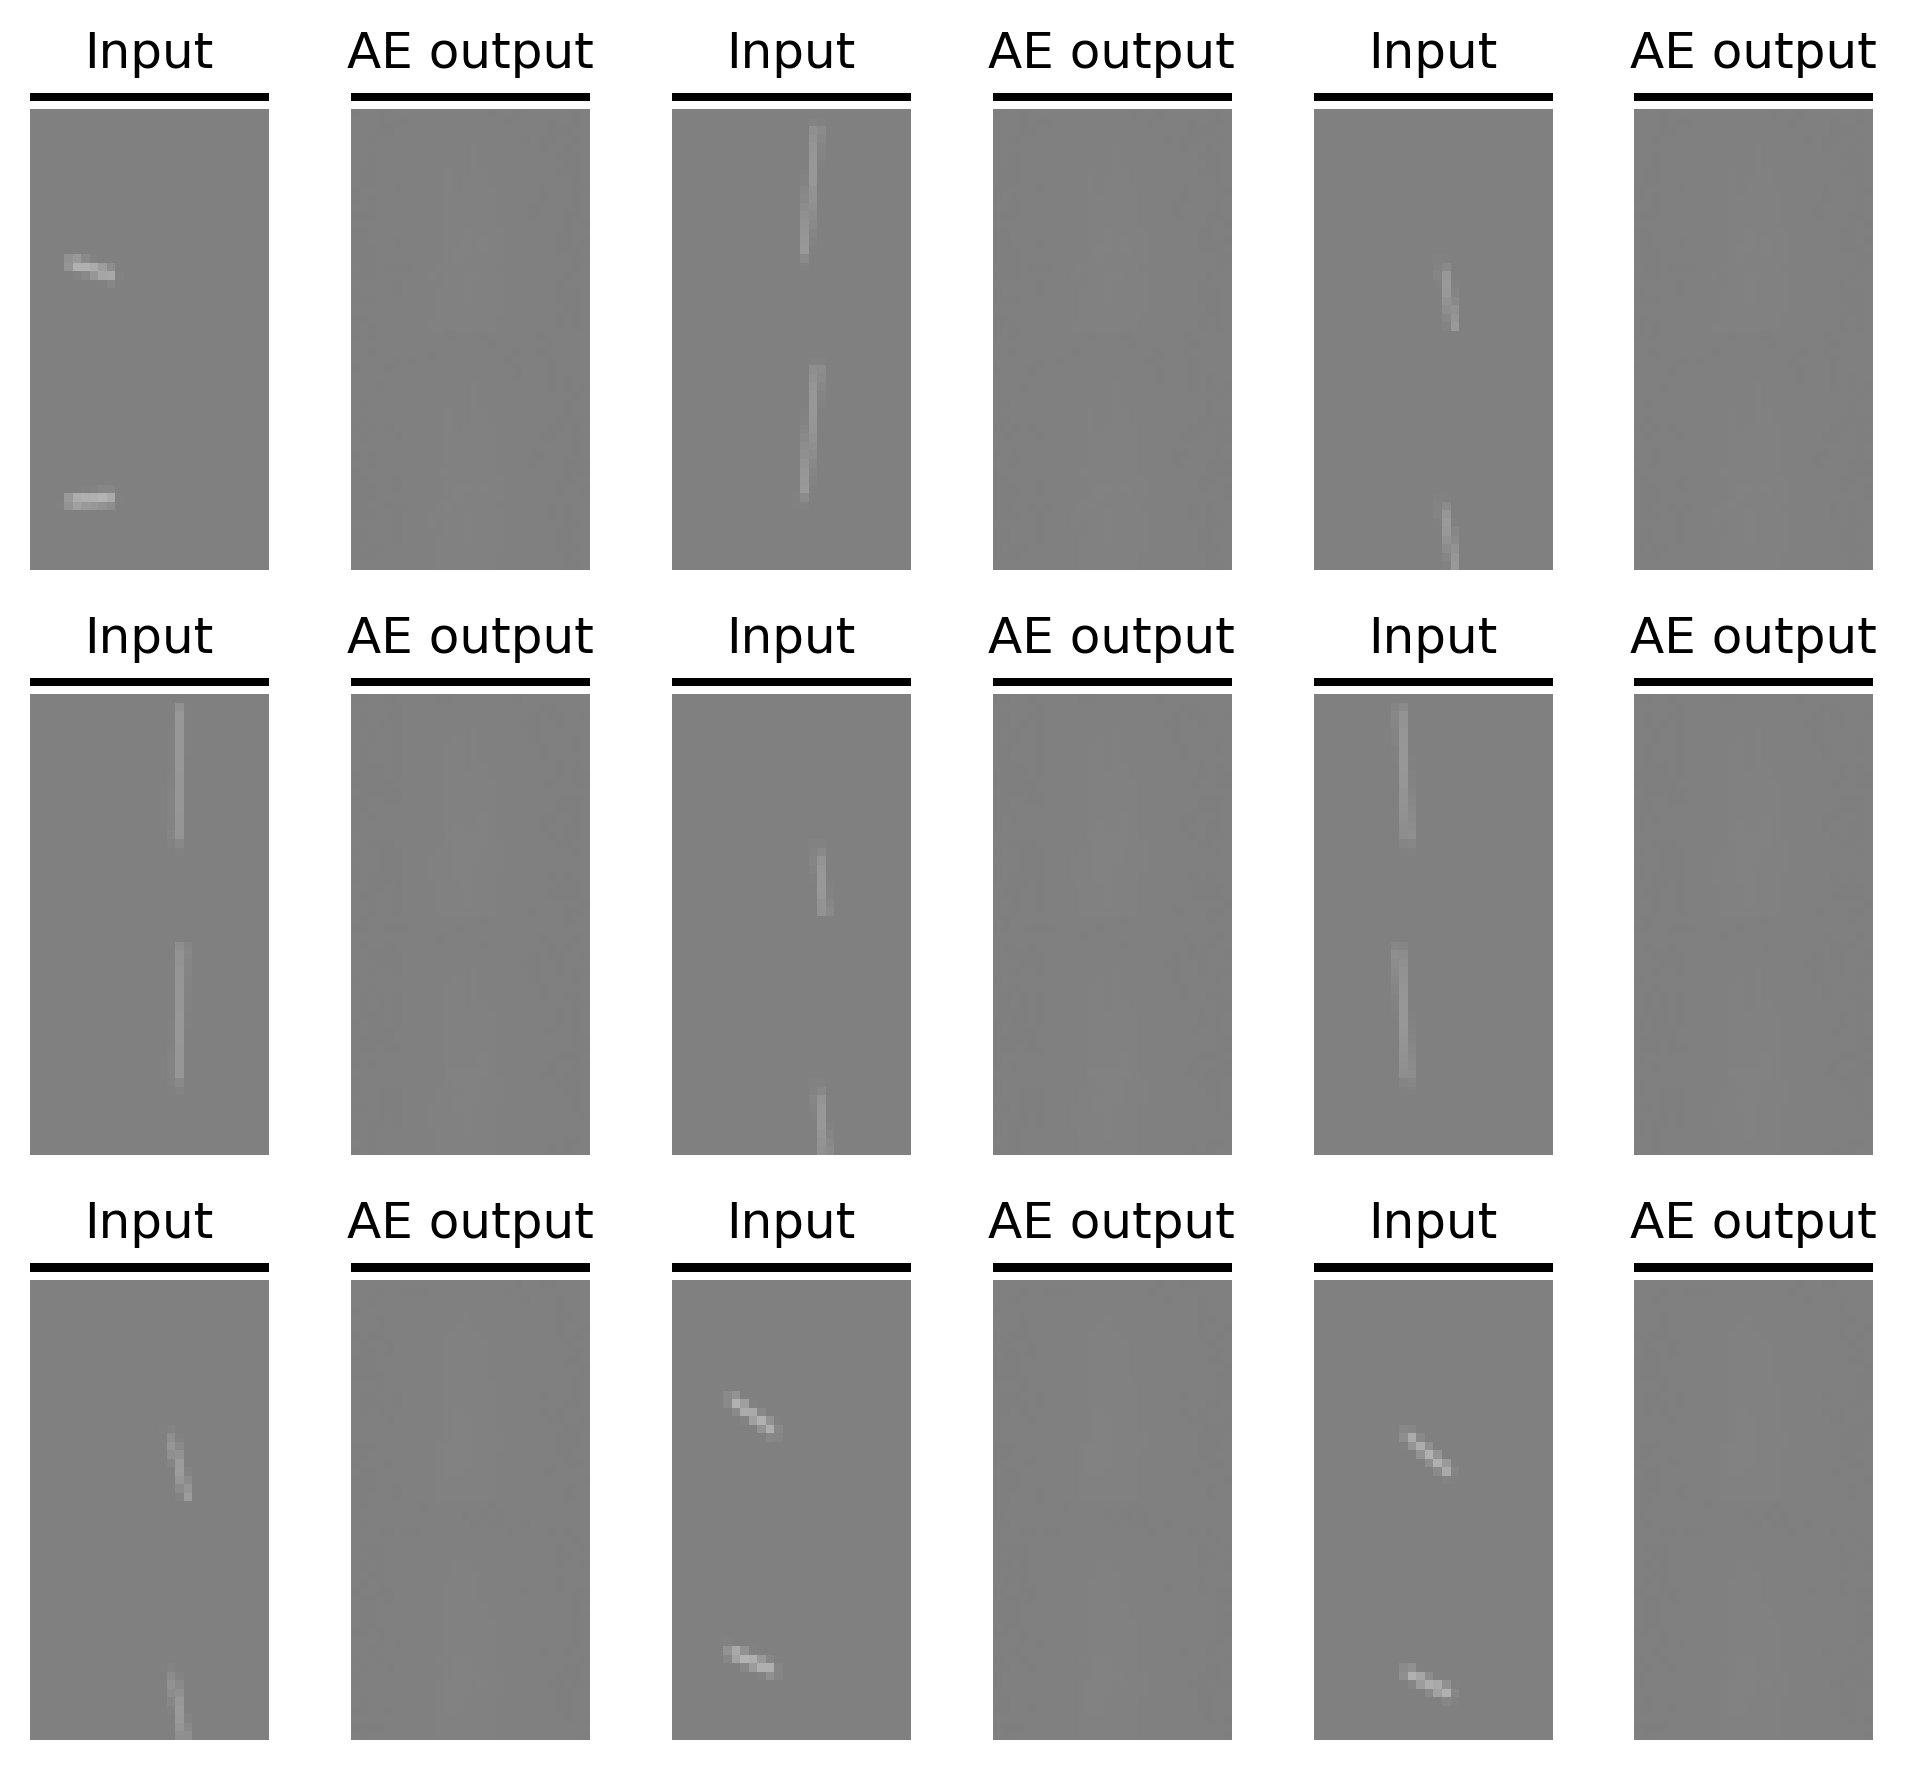

In [10]:
rows, cols = 3, 3
fig = plt.figure(figsize=[1.1*2*cols, 2*rows], dpi=DPI)

x = torch.tensor( data['pixels'], dtype=torch.float32)
x_next = torch.tensor( data['next_pixels'], dtype=torch.float32)

ixs = torch.randperm(x.shape[0])[:2*rows*cols]
bx, bx_next = x[ixs], x_next[ixs]

# hnn
r=0
bx_hat_next = hnn_model.autoencoder(bx_next)

for c in range(cols):
    ix = r*2*cols + 2*c
    # plot true image
    plt.subplot(rows, 2*cols, ix + 1)
    im = bx_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
    
    # plot true image
    plt.subplot(rows, 2*cols, ix + 2)
    im = bx_hat_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
    
# sym
r=1
bx_hat_next = sym_model.autoencoder(bx_next)

for c in range(cols):
    ix = r*2*cols + 2*c
    # plot true image
    plt.subplot(rows, 2*cols, ix + 1)
    im = bx_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
    
    # plot true image
    plt.subplot(rows, 2*cols, ix + 2)
    im = bx_hat_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
    
# lag
r=2
bx_hat_next = lag_model.autoencoder(bx_next)

for c in range(cols):
    ix = r*2*cols + 2*c
    # plot true image
    plt.subplot(rows, 2*cols, ix + 1)
    im = bx_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
    
    # plot true image
    plt.subplot(rows, 2*cols, ix + 2)
    im = bx_hat_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
    
    
plt.tight_layout() ; plt.show()
fig.savefig('{}/autoencoder-hnn.{}'.format(args.fig_dir, FORMAT))

## How does the latent space look?

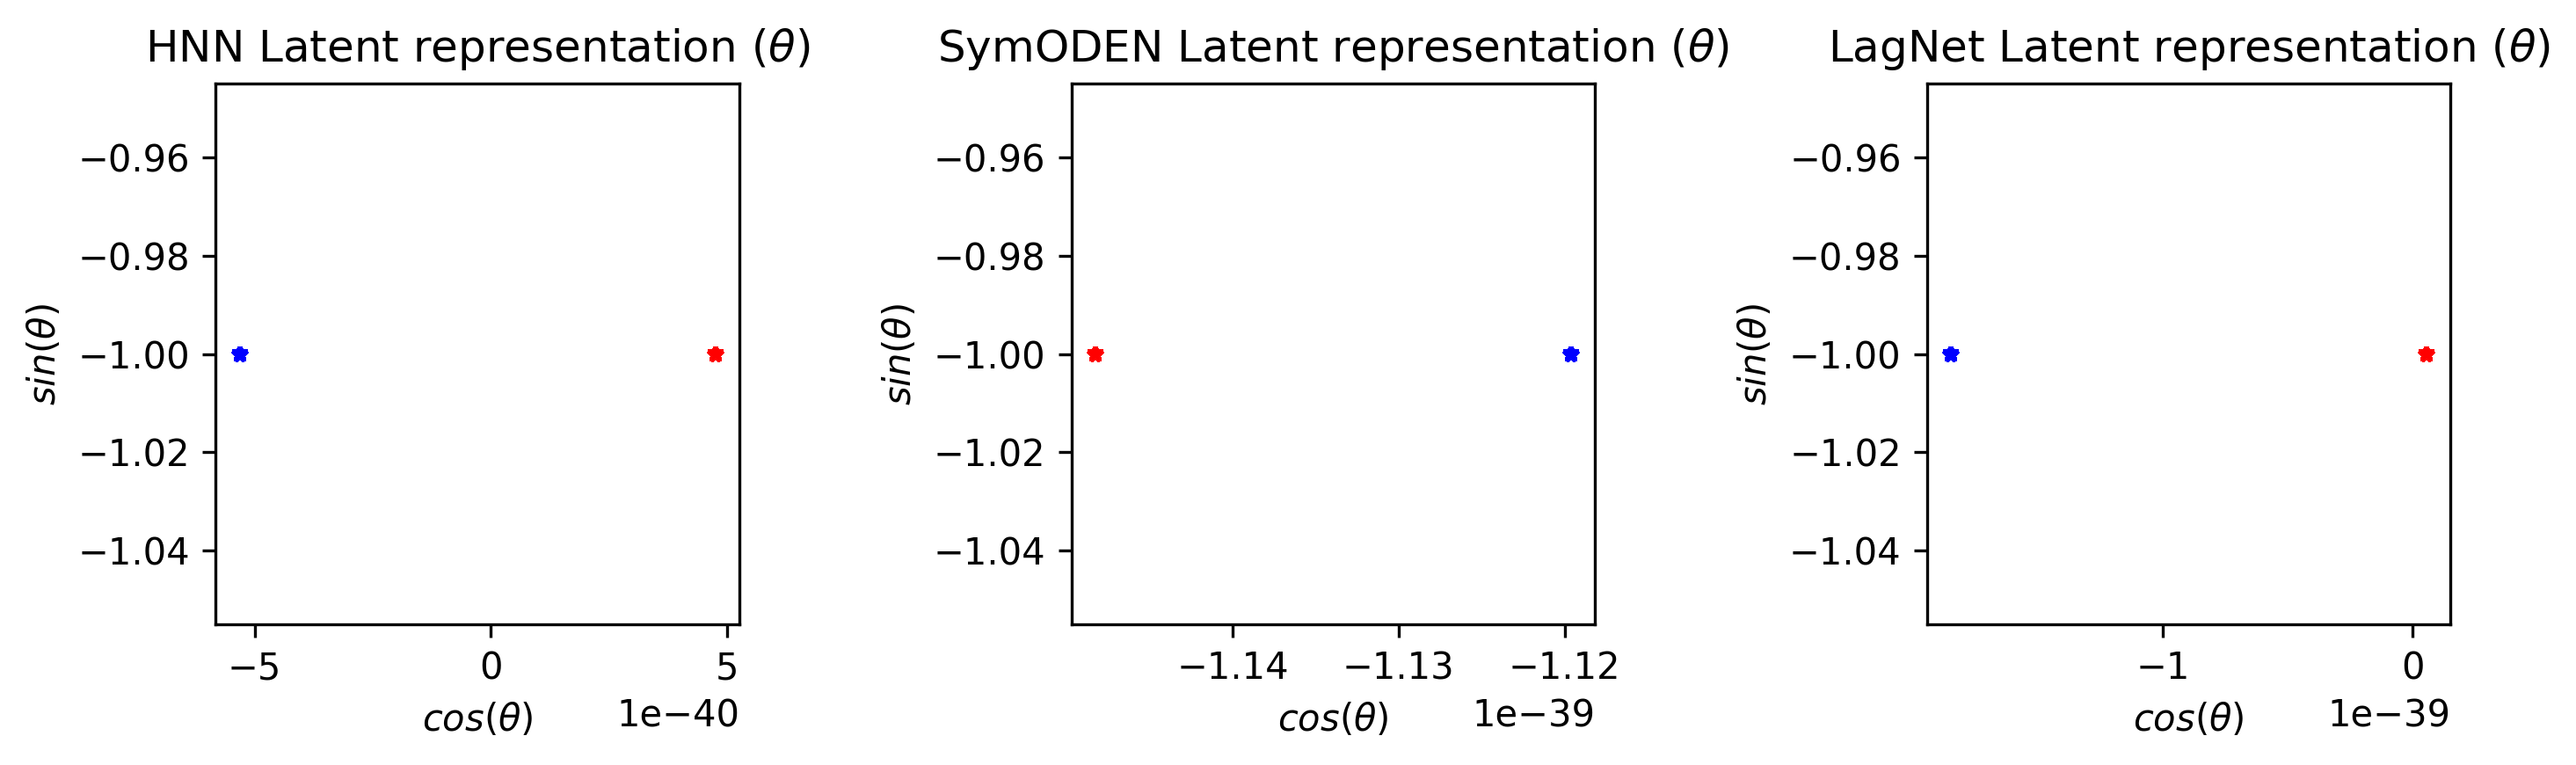

In [11]:
k = 3000
fig = plt.figure(figsize=(9.75, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 3, 1, frameon=True)
hnn_latents = hnn_model.encode(x).detach().numpy()
plt.plot(np.sin(hnn_latents[:k,0]), -np.cos(hnn_latents[:k,0]), 'b*', markersize=4)
# ax = fig.add_subplot(3, 3, 4, frameon=True)
plt.plot(np.sin(hnn_latents[:k,1]), -np.cos(hnn_latents[:k,1]), 'r*', markersize=4)

ax.set_xlabel("$cos(\\theta)$")
ax.set_ylabel("$sin(\\theta)$")
plt.title("HNN Latent representation ($\\theta$)")

ax = fig.add_subplot(1, 3, 2, frameon=True)
sym_latents = sym_model.encode(x).detach().numpy()
plt.plot(np.sin(sym_latents[:k,0]), -np.cos(sym_latents[:k,0]), 'b*', markersize=4)
# ax = fig.add_subplot(3, 3, 5, frameon=True)
plt.plot(np.sin(sym_latents[:k,1]), -np.cos(sym_latents[:k,1]), 'r*', markersize=4)

ax.set_xlabel("$cos(\\theta)$")
ax.set_ylabel("$sin(\\theta)$")
plt.title("SymODEN Latent representation ($\\theta$)")

ax = fig.add_subplot(1, 3, 3, frameon=True)
lag_latents = lag_model.encode(x).detach().numpy()
plt.plot(np.sin(lag_latents[:k,0]), -np.cos(lag_latents[:k,0]), 'b*', markersize=4)
# ax = fig.add_subplot(3, 3, 6, frameon=True)
plt.plot(np.sin(lag_latents[:k,1]), -np.cos(lag_latents[:k,1]), 'r*', markersize=4)

ax.set_xlabel("$cos(\\theta)$")
ax.set_ylabel("$sin(\\theta)$")
plt.title("LagNet Latent representation ($\\theta$)")

plt.tight_layout() ; plt.show()
fig.savefig('{}/latents-hnn.{}'.format(args.fig_dir, FORMAT))

## Compare to actual angular quantities

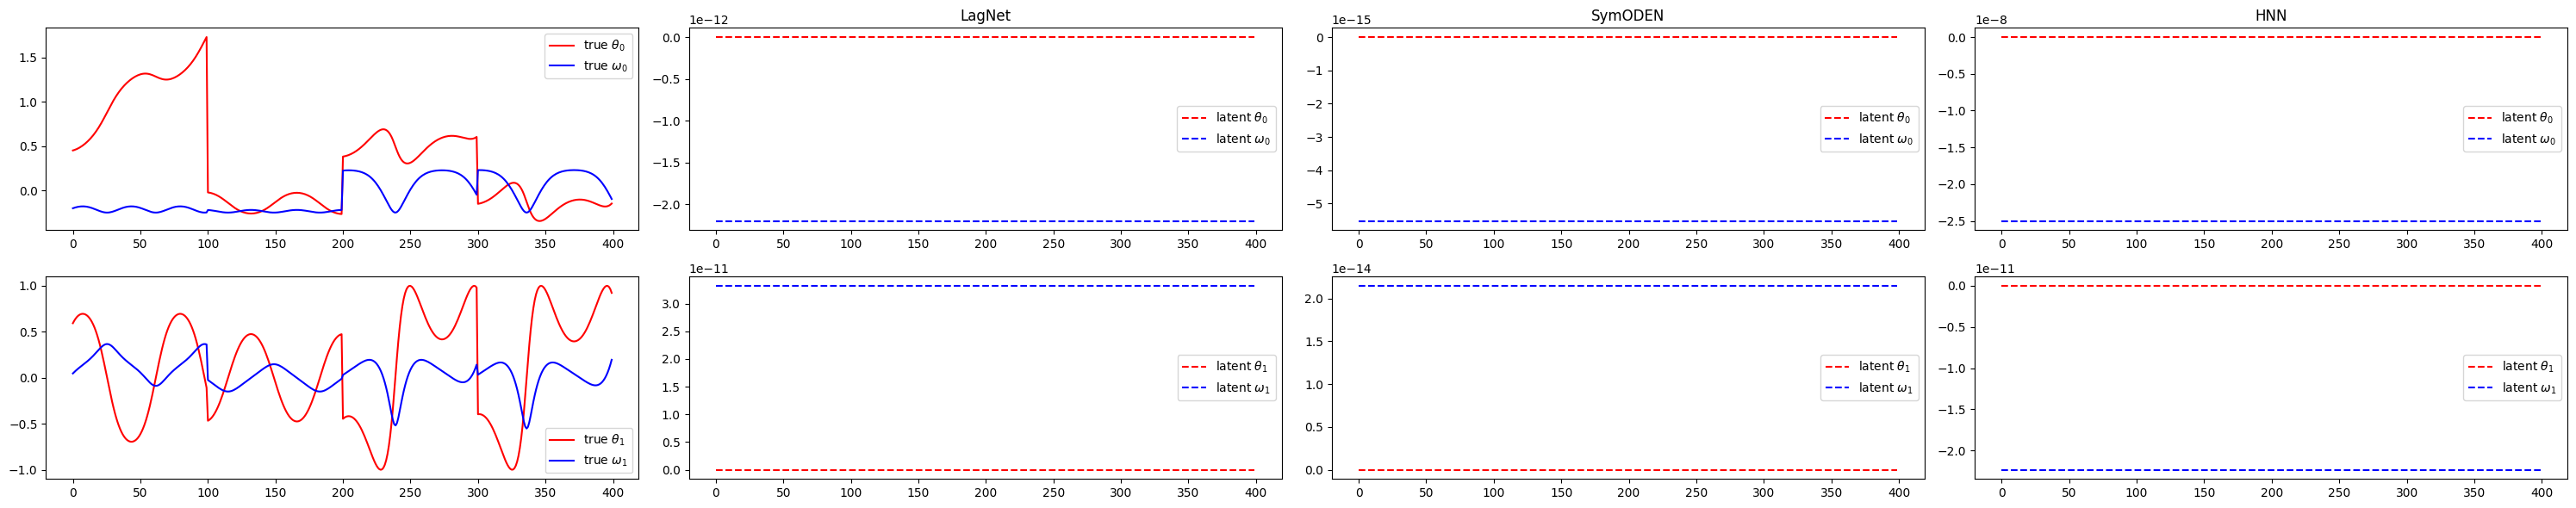

In [12]:
k = 400
fig = plt.figure(figsize=[30,6], dpi=100)
plt.subplot(2,4,1)
plt.plot(data['coords'][:k,0], "r-", label='true $\\theta_0$')    # ground truth coordinates (theta and omega)
plt.plot(data['coords'][:k,2], "b-", label='true $\omega_0$')
plt.legend()
plt.subplot(2,4,5)
plt.plot(data['coords'][:k,1], "r-", label='true $\\theta_1$')    # ground truth coordinates (theta and omega)
plt.plot(data['coords'][:k,3], "b-", label='true $\omega_1$')
plt.legend()

plt.subplot(2,4,4)
plt.title('HNN')
plt.plot(hnn_latents[:k,0], "r--", label='latent $\\theta_0$')   # learned by hnn autoencoder (in an unsupervised manner)
plt.plot(hnn_latents[:k,2], "b--", label='latent $\omega_0$')
plt.legend()
plt.subplot(2,4,8)
plt.plot(hnn_latents[:k,1], "r--", label='latent $\\theta_1$')    # ground truth coordinates (theta and omega)
plt.plot(hnn_latents[:k,3], "b--", label='latent $\omega_1$')
plt.legend()

plt.subplot(2,4,3)
plt.title('SymODEN')
plt.plot(sym_latents[:k,0], "r--", label='latent $\\theta_0$')   # learned by sym autoencoder (in an unsupervised manner)
plt.plot(sym_latents[:k,2], "b--", label='latent $\omega_0$')
plt.legend()
plt.subplot(2,4,7)
plt.plot(sym_latents[:k,1], "r--", label='latent $\\theta_1$')    # ground truth coordinates (theta and omega)
plt.plot(sym_latents[:k,3], "b--", label='latent $\omega_1$')
plt.legend()

plt.subplot(2,4,2)
plt.title('LagNet')
plt.plot(lag_latents[:k,0], "r--", label='latent $\\theta_0$')   # learned by lag autoencoder (in an unsupervised manner)
plt.plot(lag_latents[:k,2], "b--", label='latent $\omega_0$')
plt.legend()
plt.subplot(2,4,6)
plt.plot(lag_latents[:k,1], "r--", label='latent $\\theta_1$')    # ground truth coordinates (theta and omega)
plt.plot(lag_latents[:k,3], "b--", label='latent $\omega_1$')
plt.legend()

plt.tight_layout() ; plt.show()

## Plot phase space

In [ ]:
# set domain
gs = 10
xmin, xmax = hnn_latents[:,0].min(), hnn_latents[:,0].max()
ymin, ymax = hnn_latents[:,1].min(), hnn_latents[:,1].max()
umin, umax = hnn_latents[:,2].min(), hnn_latents[:,2].max()
vmin, vmax = hnn_latents[:,3].min(), hnn_latents[:,3].max()

# feed through HNN model
gX, gY, gU, gV = np.meshgrid(np.linspace(xmin, xmax, gs), np.linspace(ymin, ymax, gs), 
                     np.linspace(umin, umax, gs), np.linspace(vmin, vmax, gs))
np_mesh_inputs = np.stack([gX.flatten(), gY.flatten(), gU.flatten(), gV.flatten()]).T
mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)

# get scalar fields
F1, F2 = hnn_model.hnn(mesh_inputs)
np_F1, np_F2 = F1.data.numpy().reshape(gs,gs,gs,gs), F2.data.numpy().reshape(gs,gs,gs,gs)

# plot phase space
fig = plt.figure(figsize=(9.45, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 3, 1, frameon=True)
plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("HNN phase space")

# plot data points
k = 30 ; t = 100
c = np.linspace(0, 10, k)
plt.scatter(hnn_latents[:,0][t:t+k], hnn_latents[:,1][t:t+k], c=c, cmap='viridis', label='real data points')

# sym scalar field
xmin, xmax = sym_latents[:,0].min(), sym_latents[:,0].max()
vmin, vmax = sym_latents[:,1].min(), sym_latents[:,1].max()

# feed through SymODEN model
gX, gV = np.meshgrid(np.linspace(xmin, xmax, gs), np.linspace(vmin, vmax, gs))
np_mesh_inputs = np.stack([gX.flatten(), gV.flatten()]).T
mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)

sym_F2 = sym_model.symoden(mesh_inputs).data.numpy().reshape(gs,gs)

ax = fig.add_subplot(1, 3, 2, frameon=True)
plt.contourf(gX, gV, sym_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("SymODEN phase space")

k = 30 ; t = 100
c = np.linspace(0, 10, k)
plt.scatter(sym_latents[:,0][t:t+k], sym_latents[:,1][t:t+k], c=c, cmap='viridis', label='real data points')


# lagnet scalar field
xmin, xmax = lag_latents[:,0].min(), lag_latents[:,0].max()
vmin, vmax = lag_latents[:,1].min(), lag_latents[:,1].max()

# feed through LagNet model
gX, gV = np.meshgrid(np.linspace(xmin, xmax, gs), np.linspace(vmin, vmax, gs))
np_mesh_inputs = np.stack([gX.flatten(), gV.flatten()]).T
mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)

lag_F2 = lag_model.lag(mesh_inputs).data.numpy().reshape(gs,gs)

ax = fig.add_subplot(1, 3, 3, frameon=True)
plt.contourf(gX, gV, lag_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1$ (analogous to $\dot \\theta$)")
plt.title("LagNet phase space")

k = 30 ; t = 100
c = np.linspace(0, 10, k)
plt.scatter(lag_latents[:,0][t:t+k], lag_latents[:,1][t:t+k], c=c, cmap='viridis', label='real data points')



plt.legend(fancybox=True, framealpha=.5, fontsize=7)
plt.tight_layout() ; plt.show()
fig.savefig('{}/learned-phase-space.{}'.format(args.fig_dir, FORMAT))

## Plot total energy

In [ ]:
k = 1000
fig = plt.figure(figsize=[5,6], dpi=DPI)

# hnn
z_values = hnn_model.encode(x[:k])
F1, F2 = hnn_model.hnn(z_values)
energy = F2.detach().numpy()

ax = fig.add_subplot(3, 1, 1, frameon=True)
plt.plot(energy)
plt.title("Total HNN energy")
plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))

# symoden
z_values = sym_model.encode(x[:k])
energy = sym_model.symoden(z_values).detach().numpy()

ax = fig.add_subplot(3, 1, 2, frameon=True)
plt.plot(energy)
plt.title("Total SymODEN energy")
plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))

# symoden
z_values = lag_model.encode(x[:k])
energy = lag_model.lag(z_values).detach().numpy()

ax = fig.add_subplot(3, 1, 3, frameon=True)
plt.plot(energy)
plt.title("Total LagNet energy")
plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))


plt.tight_layout() ; plt.show()
fig.savefig('{}/total-energy.{}'.format(args.fig_dir, FORMAT))

## Integrate models in latent space
### Start by getting a real trajectory. Then see how well our models match it

In [ ]:
num_frames = 20 # 200
test_data = make_gym_dataset(seed=1, timesteps=num_frames+3, trials=1, test_split=0 ,max_angle=np.pi/10, min_angle=np.pi/11)

# load dataset
side = test_data['meta']['side']

real_pixel_traj = test_data['pixels'][:,:side**2].reshape(-1, side, side)[:num_frames]
name = '{}-truth'.format(args.name)
gifname = make_gif(real_pixel_traj, args.fig_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

### Integrate models to get a simulated trajectories

In [ ]:
# get initial values of latents
x0 = torch.tensor( test_data['pixels'][0:1], dtype=torch.float32)
hnn_y0 = hnn_model.encode(x0).detach().numpy().squeeze()
sym_y0 = sym_model.encode(x0).detach().numpy().squeeze()
lag_y0 = lag_model.encode(x0).detach().numpy().squeeze()

# integrator settings
t_span = [0, 0.98*num_frames]
point_density = num_frames / t_span[-1]
t_eval = np.linspace(t_span[0], t_span[1], num_frames)

# integrate models
# Here we don't compute t_eval[0] because it's the initial state of the system
#   and thus is already known.
hnn_traj = integrate_model(hnn_model, t_span, hnn_y0, t_eval=t_eval[1:])
sym_traj = integrate_model(sym_model, t_span, sym_y0, t_eval=t_eval[1:])
lag_traj = integrate_model(lag_model, t_span, lag_y0, t_eval=t_eval[1:])

In [ ]:
plt.plot(np.sin(hnn_traj['y'][0]), -np.cos(hnn_traj['y'][0]), label='HNN')
plt.plot(np.sin(sym_traj['y'][0]), -np.cos(sym_traj['y'][0]), label='SymODEN')
plt.plot(np.sin(lag_traj['y'][0]), -np.cos(lag_traj['y'][0]), label='LagNet')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.plot(np.sin(hnn_traj['y'][1]), -np.cos(hnn_traj['y'][1]), label='HNN')
plt.plot(np.sin(sym_traj['y'][1]), -np.cos(sym_traj['y'][1]), label='SymODEN')
plt.plot(np.sin(lag_traj['y'][1]), -np.cos(lag_traj['y'][1]), label='LagNet')
plt.legend(loc='upper right')
plt.show()

### Decode into latent space and animate

In [ ]:
# get initial values of latents
hnn_zs = torch.tensor( hnn_traj['y'].T, dtype=torch.float32)
sym_zs = torch.tensor( sym_traj['y'].T, dtype=torch.float32)
lag_zs = torch.tensor( lag_traj['y'].T, dtype=torch.float32)

hnn_pixel_traj = hnn_model.decode(hnn_zs).detach().numpy()
sym_pixel_traj = sym_model.decode(sym_zs).detach().numpy()
lag_pixel_traj = lag_model.decode(lag_zs).detach().numpy()

_hnn_pixel_traj = hnn_pixel_traj[:,:side**2].reshape(-1, side, side)
_sym_pixel_traj = sym_pixel_traj[:,:side**2].reshape(-1, side, side)
_lag_pixel_traj = lag_pixel_traj[:,:side**2].reshape(-1, side, side)

# set initial values
x0 = real_pixel_traj[0:1]
_hnn_pixel_traj = np.concatenate([x0, _hnn_pixel_traj],axis=0)
_sym_pixel_traj = np.concatenate([x0, _sym_pixel_traj],axis=0)
_lag_pixel_traj = np.concatenate([x0, _lag_pixel_traj],axis=0)

trajs = np.concatenate([real_pixel_traj,
                        _lag_pixel_traj,
                        _sym_pixel_traj,
                        _hnn_pixel_traj], axis=-1)

### Add text labels to the GIF

In [ ]:
# add whitespace to top
frac = 1/4.
padding = int(frac*side)
zero_tensor = np.zeros_like(trajs)[:,:padding]
trajs = np.concatenate([zero_tensor, trajs], axis=1)

# make and save a GIF
name = '{}-compare'.format(args.name)
pixels = [4*150, int((1+frac)*150)] # dimensions of GIF in pixels
gifname = make_gif(trajs, args.fig_dir, name=name, duration=1e-1, pixels=pixels, divider=padding)

# reload GIF and add text labels to it
im = Image.open(gifname)
frames = []
# Loop over each frame in the animated image
for frame in ImageSequence.Iterator(im):
    # Draw the text on the frame
    d = ImageDraw.Draw(frame)
    font = ImageFont.truetype("/usr/share/fonts/truetype/ttf-bitstream-vera/VeraMono.ttf", 14)
    d.text((33,7), "Ground truth", font=font)
    d.text((175,7), "LagNet", font=font)
    d.text((445,7), "SymODEN", font=font)
    d.text((310,7), "HNN", font=font)
    del d

    # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
    # To be efficient, we will save it to a stream, rather than to file
    b = io.BytesIO()
    frame.save(b, format="GIF")
    frame = Image.open(b)

    # Then append the single frame image to a list of frames
    frames.append(frame)
# Save the frames as a new image
name = "{}/{}-compare-labeled.gif".format(args.fig_dir, args.name)
frames[0].save(name, save_all=True, append_images=frames[1:])

display.Image(filename=name, width=400)

### We can also add energy via integration of the HNN

In [ ]:
def hnn_conserve_energy(t, np_x):
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    x = x.view(1, np.size(np_x))
    dx = hnn_model.time_derivative(x).data.numpy().reshape(-1)
    return dx
    
def hnn_add_energy(t, np_x):
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    x = x.view(1, np.size(np_x)) # batch size of 1
    _, F2 = hnn_model.hnn(x)
    dx = torch.autograd.grad(F2.sum(), x, create_graph=True)[0]
    np_dx = dx.data.numpy().reshape(-1)
    return np_dx

In [ ]:
frames = 500

t_span1, t_span2, t_span3 = [0,50.], [0,1.4], [0,60]
t_tot = t_span1[-1] + t_span2[-1] + t_span3[-1]
point_density = frames/t_tot
t_evals = lambda t_span: int( (t_span[1] - t_span[0])*point_density )

y0 = np.asarray([.8, 0])
kwargs = {'t_eval': np.linspace(t_span1[0], t_span1[1], t_evals(t_span1))}
path1 = integrate_model(hnn_model, t_span1, y0, fun=hnn_conserve_energy, **kwargs)

y0 = path1['y'][:,-1]
kwargs = {'t_eval': np.linspace(t_span2[0], t_span2[1], t_evals(t_span2)), 'rtol': 1e-12}
path2 = integrate_model(hnn_model, t_span2, y0, fun=hnn_add_energy, **kwargs)

y0 = path2['y'][:,-1]
kwargs = {'t_eval': np.linspace(t_span3[0], t_span3[1], t_evals(t_span3))}
path3 = integrate_model(hnn_model, t_span3, y0, fun=hnn_conserve_energy, **kwargs)

y = np.concatenate([path1['y'], path2['y'], path3['y']], axis=-1).T

# y.shape[0] % LINE_SEGMENTS should be 0
terminal_ix = LINE_SEGMENTS * (y.shape[0]//LINE_SEGMENTS)
y = y[:terminal_ix]

### Visualize integration

In [ ]:
fig = plt.figure(figsize=(3.15, 3), facecolor='white', dpi=DPI)

ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
for i, l in enumerate(np.split(y, LINE_SEGMENTS)):
    
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    label = None
    if i==0:
        label = 'Initial t'
    elif i==LINE_SEGMENTS-1:
        label = 'Final t'
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH, label=label)
plt.legend(fontsize=8)

ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
# ax.set_title("Integrating HNN in latent space")

ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")

plt.tight_layout() ; plt.show()
fig.savefig('{}/integrate-latent-hnn.{}'.format(args.fig_dir, FORMAT))

### Project back into pixel space and render

In [ ]:
# back to pixel space
y_gif = y[::2]
simulated_latents = torch.tensor( y_gif, dtype=torch.float32)
simulated_pixels = hnn_model.decode(simulated_latents)
addenergy_traj = simulated_pixels.data.numpy()[:,:side**2].reshape(-1,side,side)

# add whitespace to top
frac = 1/4.
padding = int(frac*side)
zero_tensor = np.zeros_like(addenergy_traj)[:,:padding]
addenergy_traj = np.concatenate([zero_tensor, addenergy_traj], axis=1)

# make and save a GIF
name = '{}-addenergy'.format(args.name)
pixels = [1*150, int((1+frac)*150)] # dimensions of GIF in pixels
gifname = make_gif(addenergy_traj, args.fig_dir, name=name, duration=5e-2, pixels=pixels, divider=padding)

# reload GIF and add text labels to it
im = Image.open(gifname)
frames = []
# Loop over each frame in the animated image
for frame in ImageSequence.Iterator(im):
    # Draw the text on the frame
    d = ImageDraw.Draw(frame)
    font = ImageFont.truetype("FreeMono.ttf", 14)
    d.text((20,7), "Adding energy", font=font)
    d.text((8,70), "x(t)", font=font)
    d.text((8,138), "v(t)", font=font)
    del d

    # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
    # To be efficient, we will save it to a stream, rather than to file
    b = io.BytesIO()
    frame.save(b, format="GIF")
    frame = Image.open(b)

    # Then append the single frame image to a list of frames
    frames.append(frame)
# Save the frames as a new image
name = "{}/{}-addenergy-labeled.gif".format(args.fig_dir, args.name)
frames[0].save(name, save_all=True, append_images=frames[1:])

display.Image(filename=name, width=130)

## Evaluate energy in a qualitative way
This is a bit tricky, since we've learned everything straight from pixels. But we'll do our best.

First, we need to learn a linear mapping from $z$-space to canonical coordinates. We'll do this so that we can measure (approximately) the energy of the trajectories we integrated above.

In [ ]:
def learn_z2canonical(pixels, coords, model, train_steps=4000):
    '''Learn mapping from z space to canonical coordinates'''
    cc = torch.tensor( coords, dtype=torch.float32) # canonical coords
    x = torch.tensor( pixels, dtype=torch.float32) # pixels
    z = model.encode(x).detach()
    
    z2cc = torch.nn.Linear(2,2) # linear layer that we're going to learn // could also use MLP(2,50,2)
    optim = torch.optim.Adam(z2cc.parameters(), args.learn_rate)
    
    for i in range(train_steps+1):
        ixs = torch.randperm(z.shape[0])[:400]
        loss = L2_loss(z2cc(z[ixs]), cc[ixs])
        loss.backward() ; optim.step() ; optim.zero_grad()
        if i % 1000 ==0:
            print("step {}, train_loss {:.4e}".format(i, loss.item()))
    return z2cc

def pix2cc(model, pixels, z2cc=None):
    if z2cc is None:
        z2cc = learn_z2canonical(data['pixels'], data['coords'], model)
        
    x = torch.tensor( pixels, dtype=torch.float32)
    z = hnn_model.encode(x)
    cc = z2cc(z).detach().numpy()
    return cc

#### ESTIMATE CANONICAL COORDINATES
true_cc = test_data['coords']
print('\nGetting HNN canonical coords')
hnn_cc = pix2cc(hnn_model, hnn_pixel_traj)
print('Getting SymODEN canonical coords')
sym_cc = pix2cc(sym_model, sym_pixel_traj)
print('Getting LagNet canonical coords')
lag_cc = pix2cc(lag_model, lag_pixel_traj)

y0 = true_cc[0:1]
lag_cc = np.concatenate([y0, lag_cc], axis=0)
hnn_cc = np.concatenate([y0, hnn_cc], axis=0)
sym_cc = np.concatenate([y0, sym_cc], axis=0)

#### USE THEM TO ESTIMATE TOTAL ENERGY
true_e = np.stack([hamiltonian_fn(c) for c in true_cc])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_cc])
sym_e = np.stack([hamiltonian_fn(c) for c in sym_cc])
lag_e = np.stack([lag_energy_fn(c) for c in lag_cc])

## Make a principled plot of pendulum rollout + energies

In [ ]:
N = 18
tmax = 100
b = 5
k = tmax // N
true_seq = real_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
true_seq = (true_seq.clip(-.5,.5) + .5)*255

lag_seq = _lag_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
lag_seq = (lag_seq.clip(-.5,.5) + .5)*255

hnn_seq = _hnn_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
hnn_seq = (hnn_seq.clip(-.5,.5) + .5)*255

sym_seq = _sym_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
sym_seq = (sym_seq.clip(-.5,.5) + .5)*255

sy = 8
sx = .55*sy*(28.-2*b)/28

#### USE THEM TO ESTIMATE TOTAL ENERGY
true_e = np.stack([hamiltonian_fn(c) for c in true_cc])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_cc])
sym_e = np.stack([hamiltonian_fn(c) for c in sym_cc])
lag_e = np.stack([lag_energy_fn(c) for c in lag_cc])

fs = 29 # font size
fig = plt.figure(figsize=[sx*N,3*sy], dpi=300)

plt.subplot(5,1,1)
plt.imshow(true_seq, cmap='gray')
plt.title('Ground truth', fontsize=fs, pad=15, loc='left')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(5,1,2)
plt.imshow(lag_seq, cmap='gray')
plt.title('LagNet', fontsize=fs, pad=15, loc='left', color='g')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(5,1,3)
plt.imshow(sym_seq, cmap='gray')
plt.title('SymODEN', fontsize=fs, pad=15, loc='left', color='b')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(5,1,4)
plt.imshow(hnn_seq, cmap='gray')
plt.title('HNN', fontsize=fs, pad=15, loc='left', color='r')
plt.clim(0,255) ; plt.axis('off')


plt.subplot(5,1,5)
plt.title('Pendulum angle', fontsize=fs, pad=15, loc='left')

plt.plot(t_eval[:tmax], true_cc[:tmax,0], 'k-', label='Ground truth', linewidth=3)
plt.plot(t_eval[:tmax], hnn_cc[:tmax,0], 'r-', label='HNN', linewidth=3)
plt.plot(t_eval[:tmax], sym_cc[:tmax,0], 'b-', label='SymODEN', linewidth=3)
plt.plot(t_eval[:tmax], lag_cc[:tmax,0], 'g-', label='LagNet', linewidth=3)
plt.xlabel('Time', fontsize=18)
plt.xticks(fontsize=14) ; plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='lower right')
plt.xlim(0, tmax)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pendulum-compare-static.{}'.format(args.fig_dir, FORMAT))

## Analyze conserved quantities even more thoroughly

In [ ]:
# plot trajectories in cc-space
fig = plt.figure(figsize=[8,4], dpi=DPI)
plt.subplot(1,2,1)
plt.title('Integrations mapped to ($\\theta$,$\dot \\theta$) space'.format(args.name))
plt.xlabel("$\\theta$") ; plt.ylabel("$\dot \\theta$")

plt.plot(test_data['coords'][:,0], test_data['coords'][:,1], 'k-', label='Ground truth')
plt.plot(hnn_cc[:,0], hnn_cc[:,1], 'r-', label='HNN')
plt.plot(sym_cc[:,0], sym_cc[:,1], 'b-', label='SymODEN')
plt.plot(lag_cc[:,0], lag_cc[:,1], 'g-', label='LagNet')

# plt.xlim(-.5,.5) ; plt.ylim(-1.5,2.3)
plt.legend(fontsize=8, loc='upper right')

# plot estimated energy
plt.subplot(1,2,2)
plt.title('Estimated energy') ; plt.xlabel('Time')
plt.plot(true_e, 'k', label='Ground truth')
plt.plot(hnn_e, 'r', label='HNN')
plt.plot(sym_e, 'b', label='SymODEN')
plt.plot(lag_e, 'g', label='LagNet')
plt.legend(fontsize=8)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pixhnn-energy.{}'.format(args.fig_dir, FORMAT))

## Quantitative analysis

In [ ]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

lag_distance = np_L2_dist(true_e, lag_e)
hnn_distance = np_L2_dist(true_e, hnn_e)
sym_distance = np_L2_dist(true_e, sym_e)

splits = 5
print("\nLagNet energy MSE: {:.4e} +/- {:.2e}\nSymODEN energy MSE: {:.4e} +/- {:.2e}\nHNN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(lag_distance), bootstrap_conf(lag_distance, splits),
          np.mean(sym_distance), bootstrap_conf(sym_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )